# BÀI TẬP VỀ NHÀ:
Thử lập trình mô hình đề xuất trong bài báo dưới đây cho bài toán nhận diện cảm xúc: https://www.researchgate.net/profile/Dinh_Sang/publication/321257241_Facial_expression_recognition_using_deep_convolutional_neural_networks/links/5b12a7824585150a0a619d6c/Facial-expression-recognition-using-deep-convolutional-neural-networks.pdf


# BKVGG12 with multiclass SVM loss
## Accuracy:
- Public test set: 0.6990805238227918
- Private test set: 0.7015881861242687

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/'My Drive'/'Colab Notebooks'/L12

/content/drive/My Drive/Colab Notebooks/L12


In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

Using TensorFlow backend.


## Reading data

Read label data then convert to one-hot encode

In [0]:
#one-hot encode for given class label
def one_hot(idx):
    y=np.zeros(7)
    y[idx]=1
    return y

data = pd.read_csv(os.path.join('Dataset','fer2013.csv'),delimiter=',',dtype='a')
Y = np.array([one_hot(int(idx)) for idx in data['emotion']],np.float)
print(Y.shape)
print(Y)

(35887, 7)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Read sample data using pandas, then reshape to (48,48,1)

(35887,)
(35887, 48, 48, 1)


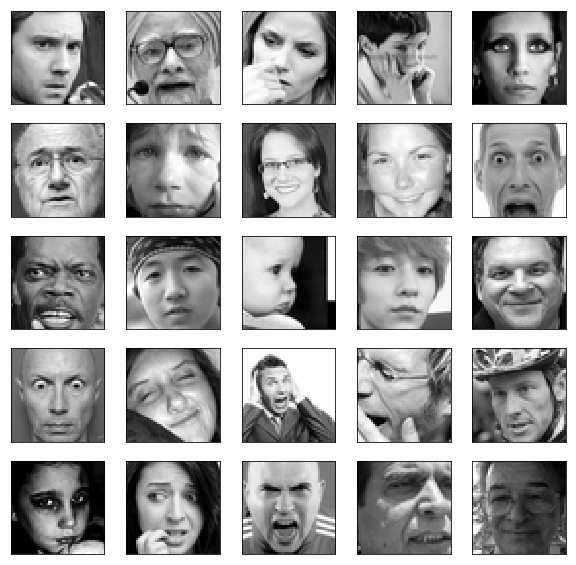

In [0]:
imagebuffer=np.array(data['pixels'])
print(imagebuffer.shape)
X = np.array([np.fromstring(image,np.uint8,sep=' ').reshape((48,48,1)) for image in imagebuffer],np.float)
del imagebuffer
print(X.shape)
plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(X[i].reshape((48,48)),cmap='gray')
  plt.xticks([])
  plt.yticks([])

Training and testing split
Can use the 3rd column of the .csv file to indicate the usage, but for simpler and faster, split data set just by indexing.   
The first 28709 samples for training set, the next 3589 ones for the public test set, and the rest 3589 for the private test set.

In [0]:
x_train=X[:28709]
y_train=Y[:28709]
x_val=X[28709:32298]
y_val=Y[28709:32298]
x_test=X[32298:]
y_test=Y[32298:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)
(3589, 48, 48, 1)
(3589, 7)


In the preprocessing data stage, I found that there was some noisy data in the training set, that could affect the result of the model. Each image, all the pixel is 0 as show below

In [0]:
#noise index list
noise=[]
for i in range(x_train.shape[0]):
  if x_train[i].any()==False:
    noise.append(i)
print(noise)

[6458, 7629, 10423, 11286, 13148, 13402, 13988, 15894, 22198, 22927, 28601]


[1. 0. 0. 0. 0. 0. 0.]


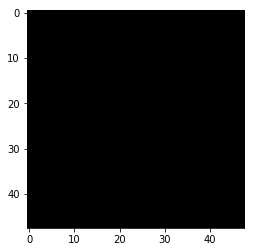

In [0]:
plt.imshow(x_train[6458].reshape(48,48),cmap='gray')
print(y_train[6458])

Remove these noises

In [0]:
x_train=np.delete(x_train,noise,0)
y_train=np.delete(y_train,noise,0)
print(x_train.shape)
print(y_train.shape)

(28698, 48, 48, 1)
(28698, 7)


Split training data to training set and validation set to evaluate the model

## Contructing model


### Image preprocessing

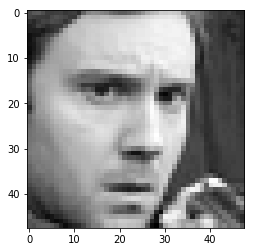

In [0]:
plt.imshow(x_train[0].reshape((48,48)),cmap='gray')

In [0]:
def get_preprocess_param(x_train):
  x=x_train.copy()
  nImage=x.shape[0]
  
  # Normalize data per image
  for idx in range(nImage):
    mean=np.mean(x[idx])
    std=np.std(x[idx])
    if std==0:
      std=1
    x[idx]=(x[idx]-mean)*(3.125/std)
    
  per_pixel_mean=np.zeros(x_train.shape[1:])
  per_pixel_std=np.zeros(x_train.shape[1:])
  
  for i in range(x.shape[1]):
    for j in range(x.shape[2]):
      per_pixel_mean[i,j,0]=np.mean(x[:,i,j,0])
      per_pixel_std[i,j,0]=np.std(x[:,i,j,0])
      
  return per_pixel_mean,per_pixel_std

In [0]:
def preprocess_data(x,per_pixel_mean,per_pixel_std):
  nImage=x.shape[0]
  
  # Normalize data per image
  for idx in range(nImage):
    mean=np.mean(x[idx])
    std=np.std(x[idx])
    if std==0:
      std=1
    x[idx]=(x[idx]-mean)*(3.125/std)

  # Normalize data per pixel
  print(per_pixel_std.shape)
  for idx in range(nImage):
    x[idx]=(x[idx]-per_pixel_mean)/per_pixel_std

In [0]:
per_pixel_mean,per_pixel_std=get_preprocess_param(x_train)
preprocess_data(x_train,per_pixel_mean,per_pixel_std)
preprocess_data(x_val,per_pixel_mean,per_pixel_std)
print(np.std(x_train[0]))
print(np.mean(x_train[0]))
print(np.mean(x_train[:,0,0]))
print(np.std(x_train[:,0,0]))

(48, 48, 1)
(48, 48, 1)
0.9334569463319046
0.04963168189525465
-1.980744959955677e-18
0.9999999999999998


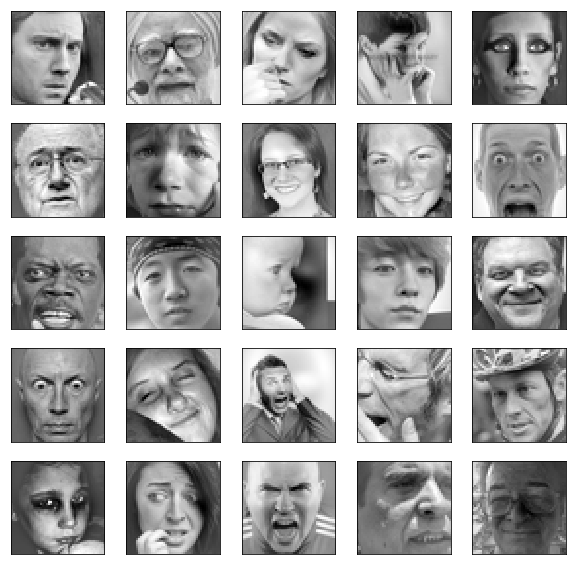

In [0]:
plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i].reshape(48,48),cmap='gray')

### Build Deep neural network BKVGG12
Build DNN model which give the best accuracy on both 2 test sets, as describe in the paper

In [0]:
from keras.engine.input_layer import Input
from keras.models import Model

def BKVGG12(img_shape=(42,42,1), num_classes=7, weight_decay=1e-4):
    # Input layer
    input = Input(img_shape)
    
    # Layer 1
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(input)
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
                     activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Layer 2
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 3
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
    
    # Layer 4
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay),
               activation='relu',kernel_initializer='he_normal', bias_initializer='zeros')(x)
    
    # Layer 5
    x = Flatten()(x)
    x = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x=Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='relu', kernel_regularizer=l2(weight_decay),kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x=Dropout(rate=0.5)(x)
    
    # Output layer
    # Multi class SVM, without softmax activation
    output = Dense(units=num_classes,kernel_initializer='he_normal', bias_initializer='zeros')(x)

    BKVGG12 = Model(inputs=input, outputs=output)
    
    return BKVGG12

In [0]:
BKVGG12().summary()

W0629 08:18:09.011479 140626118834048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 08:18:09.048507 140626118834048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 08:18:09.057637 140626118834048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0629 08:18:09.113208 140626118834048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0629 08:18:09.426384 140626118834048 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 42, 42, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

### Image augmentation

Random resize image to a squared shape between (42,42) and (54,54)

In [0]:
def random_resize(img):
  randSize=np.random.randint(42,55)
  return cv2.resize(img,(randSize,randSize))

Random crop a region of (42,42) from image

In [0]:
def random_crop(img):
    originalSize = img.shape[0]
    x_tl = np.random.randint(0, originalSize - 41)
    y_tl = np.random.randint(0, originalSize - 41)
    return img[y_tl:(y_tl+42), x_tl:(x_tl+42)].reshape((42,42,1))

Define a function that take input as a Keras ImageGen (Iterator) and generate random augmentation from the image batches generated by the original iterator

In [0]:
def resize_and_crop_generator(batches):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], 42, 42, 1))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(random_resize(batch_x[i]))
        yield (batch_crops, batch_y)

Create a batches generator for data augmentation

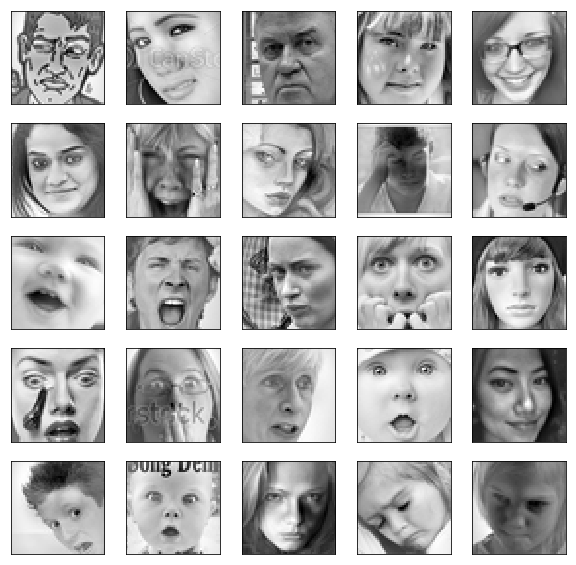

In [0]:
plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_val[i].reshape(48,48),cmap='gray')

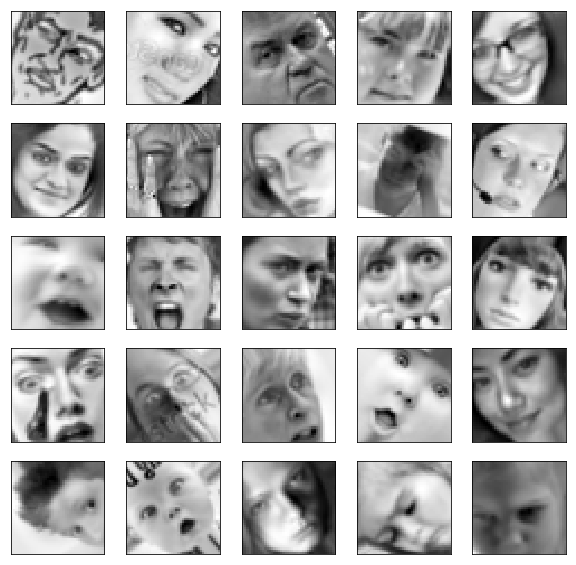

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=45,horizontal_flip=True)

rotate_and_mirror_test_generator=datagen.flow(x_val, y_val, batch_size=len(x_val),shuffle=False)
test_generator=resize_and_crop_generator(rotate_and_mirror_test_generator)

aug_x_val=np.zeros((4*x_val.shape[0],42,42,1))
aug_y_val=np.zeros((4*y_val.shape[0],7))
for i in range(4):
  aug_x_val[len(x_val)*i:len(x_val)*(i+1)],aug_y_val[len(y_val)*i:len(y_val)*(i+1)]=next(test_generator)
  

plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(aug_x_val[i].reshape(42,42),cmap='gray')

In [0]:
rotate_and_mirror_generator=datagen.flow(x_train, y_train, batch_size=256)
aug_generator=resize_and_crop_generator(rotate_and_mirror_generator)

In [0]:
print(len(aug_x_val))
# x_batch,_=next(aug_generator)

# plt.subplots(5,5,figsize=(10,10))
# for i in range(25):
#   plt.subplot(5,5,i+1)
#   plt.xticks([])
#   plt.yticks([])
#   plt.imshow(x_batch[i].reshape(42,42),cmap='gray')
  

14356


Function to calculate the multi SVM loss

In [0]:
import keras.backend as K

def multi_svm_loss(y_true, y_pred):
  correct=K.sum(y_true*y_pred,axis=-1,keepdims=True)
  return K.sum(K.square(K.maximum(0.,y_pred-correct+1.)),axis=-1)

### Training model. 
**Detail:**
- Callback function:   
  -  Model checkpoint to save best model with the highest accuracy on validation set.
  -  Reduce learning rate 10 time when model is not improved after 20 epochs
  - Early stopping when model is not improved after 50 epochs
- Stochastic Gradient Descent optimizer with default learning rate=0.001, momentum=0.9
- Multi SVM loss function as define above
- Training on maximum 1500 epochs

In [0]:
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model_checkpoint=ModelCheckpoint('best_multi_svm_model.hdf5',monitor='val_acc',save_best_only=True)
reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20,verbose=1)
early_stop=EarlyStopping(monitor='loss', min_delta=0, patience=50, restore_best_weights=False,verbose=1)

bkvgg12=BKVGG12(img_shape=(42,42,1),num_classes=7)
sgd=optimizers.SGD(lr=0.001,momentum=0.9)
bkvgg12.compile(optimizer=sgd, loss=multi_svm_loss, metrics=['accuracy'])
history=bkvgg12.fit_generator(aug_generator,validation_data=(aug_x_val,aug_y_val),steps_per_epoch=len(x_train)//256,epochs=1500, callbacks=[model_checkpoint,reduce_lr,early_stop])

Epoch 1/1500
112/112 [==============================] - 19s 166ms/step - loss: 6.9867 - acc: 0.2416 - val_loss: 6.4328 - val_acc: 0.2494
Epoch 2/1500
112/112 [==============================] - 17s 149ms/step - loss: 6.4186 - acc: 0.2540 - val_loss: 6.3921 - val_acc: 0.2494
Epoch 3/1500
112/112 [==============================] - 17s 149ms/step - loss: 6.3869 - acc: 0.2503 - val_loss: 6.3321 - val_acc: 0.2494
Epoch 4/1500
112/112 [==============================] - 17s 149ms/step - loss: 6.3196 - acc: 0.2559 - val_loss: 6.2055 - val_acc: 0.2662
Epoch 5/1500
112/112 [==============================] - 17s 150ms/step - loss: 6.2373 - acc: 0.2590 - val_loss: 6.1335 - val_acc: 0.2788
Epoch 6/1500
112/112 [==============================] - 17s 150ms/step - loss: 6.2082 - acc: 0.2645 - val_loss: 6.0694 - val_acc: 0.2924
Epoch 7/1500
112/112 [==============================] - 17s 150ms/step - loss: 6.1388 - acc: 0.2687 - val_loss: 5.9873 - val_acc: 0.2942
Epoch 8/1500
112/112 [===================

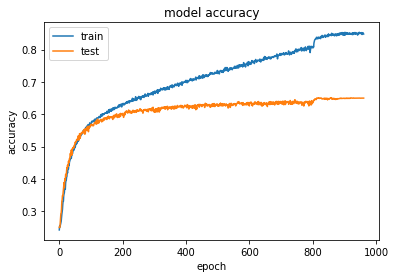

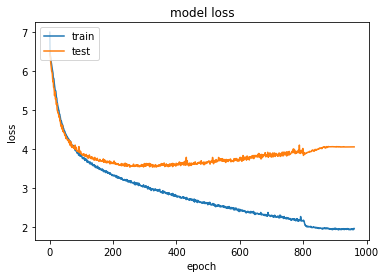

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test phase

In [0]:
preprocess_data(x_test,per_pixel_mean,per_pixel_std)

(48, 48, 1)


In [0]:
def eval2_gen(img):
  ret=np.zeros((648,42,42,1))
  idx=0
  for size in [48,50,52,54]:
    for rotation in [-45,-33.75,-22.5,-11.25,0,11.25,22.5,33.75,45]:
      #Rescale
      img1=cv2.resize(img,(size,size))
      #Rotate
      M = cv2.getRotationMatrix2D((size//2,size//2),rotation,1)
      img1=cv2.warpAffine(img1,M,(size,size))
      #Crop
      for i in range(9):
        img2=random_crop(img1)
        ret[idx]=img2
        img3=cv2.flip(img2,1)
        ret[idx+1]=img3.reshape(42,42,1)
        idx+=2
  return ret
        
        
      

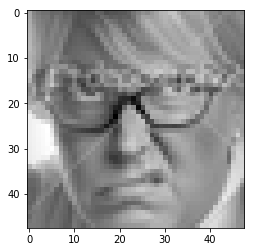

In [0]:
plt.imshow(x_test[0].reshape(48,48),cmap='gray')

648


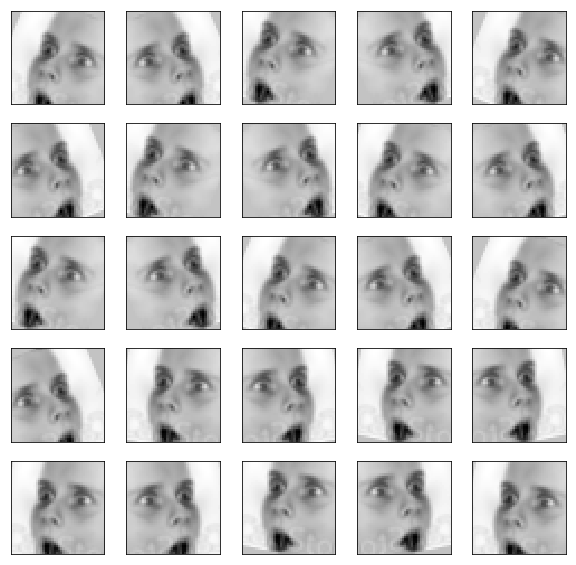

In [0]:
test_list=eval2_gen(x_val[611])
print(len(test_list))
plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_list[200+i].reshape(42,42),cmap='gray')

In [0]:
def predict(model,imgs):
  num_imgs=len(imgs)
  y_predict=np.zeros((num_imgs,7))
  for i in range(num_imgs):
    print(i)
    eval2_list=eval2_gen(imgs[i])
    temp_vec=model.predict(eval2_list)
    score_vec=np.sum(temp_vec,axis=0)
    predict_label=np.argmax(score_vec)
    y_predict[i][predict_label]=1
  return y_predict

In [0]:
y_test_predict=predict(bkvgg12,x_test)
print(y_test_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:

print(y_test_predict.shape)
print(y_test.shape)
temp=np.multiply(y_test_predict,y_test)
num_correct=np.sum(temp)
print(num_correct)
acc=num_correct/len(y_test)
print("Accuracy on private test set:",acc)

(3589, 7)
(3589, 7)
2515.0
Accuracy on private test set: 0.700752298690443


In [0]:
y_val_predict=predict(bkvgg12,x_val)
print(y_val_predict)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [0]:
print(y_val_predict.shape)
print(y_val.shape)
temp=np.multiply(y_val_predict,y_val)
num_correct=np.sum(temp)
print(num_correct)
acc=num_correct/len(y_val)
print("Accuracy on private test set:",acc)

(3589, 7)
(3589, 7)
2508.0
Accuracy on private test set: 0.6988018946781833


## BEST MODEL


In [0]:
from keras.models import load_model
best_bkvgg12 = load_model('best_multi_svm_model.hdf5',custom_objects={'multi_svm_loss':multi_svm_loss})
best_bkvgg12.summary()

W0629 17:59:12.310268 139804620732288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 42, 42, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 42, 42, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 64)        0         
__________

In [0]:
y_test_predict=predict(best_bkvgg12,x_test)
print(y_test_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:

print(y_test_predict.shape)
print(y_test.shape)
temp=np.multiply(y_test_predict,y_test)
num_correct=np.sum(temp)
print(num_correct)
acc=num_correct/len(y_test)
print("Accuracy on private test set:",acc)

(3589, 7)
(3589, 7)
2518.0
Accuracy on private test set: 0.7015881861242687


In [0]:
y_val_predict=predict(best_bkvgg12,x_val)
print(y_val_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
print(y_val_predict.shape)
print(y_val.shape)
temp=np.multiply(y_val_predict,y_val)
num_correct=np.sum(temp)
print(num_correct)
acc=num_correct/len(y_val)
print("Accuracy on private test set:",acc)

(3589, 7)
(3589, 7)
2509.0
Accuracy on private test set: 0.6990805238227918
